#  XAI BERT- Suicide Detection
**Autora:** Lais Carvalho Coutinho

**Orientador:** Adonias Caetano de Oliveira

**Instituição:** IFCE

**Dataset disponível em:**


## Instalação de Pacotes

In [ ]:
!pip install Unidecode transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.8 MB/s eta 0:00:00


## Importação de Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#text preprocessing libraries

import re
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from scipy.special import expit
from tqdm.notebook import tqdm

# import seaborn as sns
# from imblearn.under_sampling import RandomUnderSampler
# from unidecode import unidecode
# from string import punctuation
# # from wordcloud import WordCloud
# from lime.lime_text import LimeTextExplainer
# from scipy.special import expit

## Carregamento do Dataset

In [ ]:
link_train = 'link púbico do Google Drive de acesso ao CSV de treinamento'
link_test = 'link púbico do Google Drive de acesso ao CSV de teste'

file_id_link_train = link_train.split('/')[-2]
file_id_link_test = link_test.split('/')[-2]

read_link_train = 'https://drive.google.com/uc?id=' + file_id_link_train
read_link_test = 'https://drive.google.com/uc?id=' + file_id_link_test

train_dataset = pd.read_csv(read_link_train,  index_col=0)
test_dataset = pd.read_csv(read_link_test,  index_col=0)

In [ ]:
print(test_dataset.columns)

Index(['text', 'classification'], dtype='object')


In [ ]:
print(train_dataset['classification'].value_counts())

classification
1    930
0    865
Name: count, dtype: int64


## Divisão dos Dados em Conjuntos de Treinamento, Validação e Teste

In [ ]:
# Dividindo os dados de treino em treino e validação
train_df, valid_df, train_label, valid_label = train_test_split(
    train_dataset[['text']], train_dataset['classification'], test_size=0.20, random_state=42)

# Dividindo os dados de teste (já definidos)
test_df = test_dataset[['text']]
test_label = test_dataset['classification']

In [ ]:
print("Conjunto de Treinamento:")
print(train_df.head(), "\n")
print("Conjunto de Validação:")
print(valid_df.head(), "\n")
print("Conjunto de Teste:")
print(test_df.head(), "\n")

Conjunto de Treinamento:
                                                   text
1023  i have band concert today and i was excited it...
1732  i hate myself because of one stupid mistake i ...
1555  ive always felt suicidal most of my life and i...
1640  i i cant imagine dying its not something that ...
175   m in college homeless in college i feel so sad... 

Conjunto de Validação:
                                                   text
1234  every single night its been so hard just to ex...
220   days ago i slit my wrists again i was feeling ...
1516  ive been depressed quite while now and i just ...
438                                           emptypost
1268  sometimes i wonder if people that stay alive n... 

Conjunto de Teste:
                                                text
0  sometimes life can be too much we can often fe...
1  i really am having hard time with life nothing...
2  i guess you could say its to the point where i...
3  ive been depressed and i seem to be gettin

In [ ]:
# Garantir que todos os valores na coluna 'text' sejam strings
train_df['text'] = train_df['text'].fillna('').astype(str)
valid_df['text'] = valid_df['text'].fillna('').astype(str)
test_df['text'] = test_df['text'].fillna('').astype(str)

train_texts = train_df['text'].values.tolist()
valid_texts = valid_df['text'].values.tolist()
test_texts = test_df['text'].values.tolist()

In [ ]:
print(f"Train: {len(train_df)} lines")
print(f"Validation: {len(valid_df)} lines")
print(f"Test: {len(test_df)} lines")

Train: 1436 lines
Validation: 359 lines
Test: 100 lines


In [ ]:
label_names = ['non-suicide', 'suicide']
label_names

['non-suicide', 'suicide']

## Inicialização do Tokenizador e do Modelo

In [ ]:
from transformers import RobertaTokenizer

PRETRAINED_LM = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

RobertaTokenizer(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

## Definição de Funções Auxiliares

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs,
                                               add_special_tokens=True,
                                               max_length=128,
                                               padding='max_length',
                                               return_attention_mask=True,
                                               truncation=True,
                                               return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Preparação dos dados para o treinamento do modelo

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [ ]:
train_y = torch.LongTensor(train_label.values)
valid_y = torch.LongTensor(valid_label.values)
test_y = torch.LongTensor(test_label.values)

In [ ]:
N_labels = len(train_label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
train_label.unique()

array([0, 1])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.to(device)

In [ ]:
# Best results: 07 and 08
EPOCHS = 8
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

## Treinamento do modelo

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.6784874724017249 
23/23 val loss: 0.6631514352300892 
Epoch:  2


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.677578772770034 
23/23 val loss: 0.665582317373027 
Epoch:  3


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.6690622899267409 
23/23 val loss: 0.6479121835335441 
Epoch:  4


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.672320854001575 
23/23 val loss: 0.65015658347503 
Epoch:  5


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.6736319820086162 
23/23 val loss: 0.640880312608636 
Epoch:  6


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.6412550664610333 
23/23 val loss: 0.6286170832488848 
Epoch:  7


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.6085385799407959 
23/23 val loss: 0.6312155645826588 
Epoch:  8


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

90/90 train loss: 0.5910385052363077 
23/23 val loss: 0.6329024136066437 


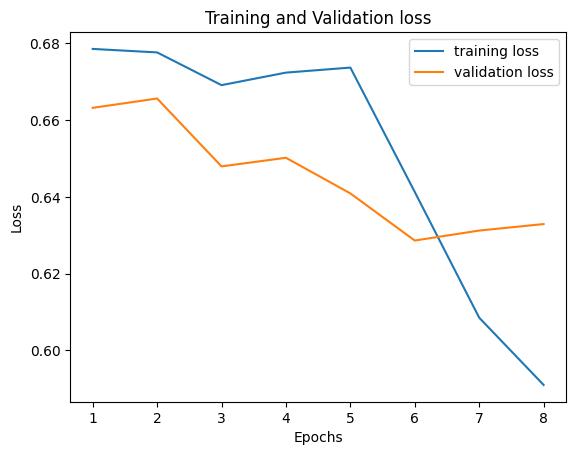

In [ ]:
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Avaliação do Modelo

In [ ]:
model.eval()
test_pred = []
test_loss= 0

with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classification report')

print(classification_report(test_pred, test_label.to_numpy(),target_names=label_names))

classification report
              precision    recall  f1-score   support

 non-suicide       0.62      0.63      0.63        49
     suicide       0.64      0.63      0.63        51

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



In [ ]:
model.eval()
probabilities = []

with torch.no_grad():
  for step_num, batch_data in tqdm(enumerate(test_dataloader)):
      input_ids, att_mask, labels = [data.to(device) for data in batch_data]
      output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

      prob = expit(output.logits.cpu().detach().numpy())

      probabilities.append( prob )

probabilities = np.concatenate(probabilities)

0it [00:00, ?it/s]

In [ ]:
probabilities

array([[0.44521144, 0.54695624],
       [0.42430833, 0.5736842 ],
       [0.55065423, 0.4605096 ],
       [0.31469724, 0.66358215],
       [0.5669893 , 0.45033905],
       [0.6963904 , 0.33798006],
       [0.36140203, 0.62855375],
       [0.38666958, 0.5943674 ],
       [0.58276165, 0.4307632 ],
       [0.12369169, 0.85025525],
       [0.4593625 , 0.5360018 ],
       [0.4415176 , 0.54934067],
       [0.43915662, 0.55617934],
       [0.51874584, 0.48427916],
       [0.4083445 , 0.57352525],
       [0.10538126, 0.8591001 ],
       [0.4452016 , 0.56951827],
       [0.6692094 , 0.35242295],
       [0.6310554 , 0.40029058],
       [0.4559133 , 0.54408425],
       [0.34276325, 0.63403773],
       [0.61200523, 0.4132062 ],
       [0.3950092 , 0.59423465],
       [0.5037485 , 0.49070293],
       [0.5228169 , 0.4866203 ],
       [0.27849233, 0.6950366 ],
       [0.5335957 , 0.48197338],
       [0.6315491 , 0.39653957],
       [0.60605586, 0.42263252],
       [0.5984758 , 0.435944  ],
       [0.

In [ ]:
print(type(test_label))
print(type(test_pred))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


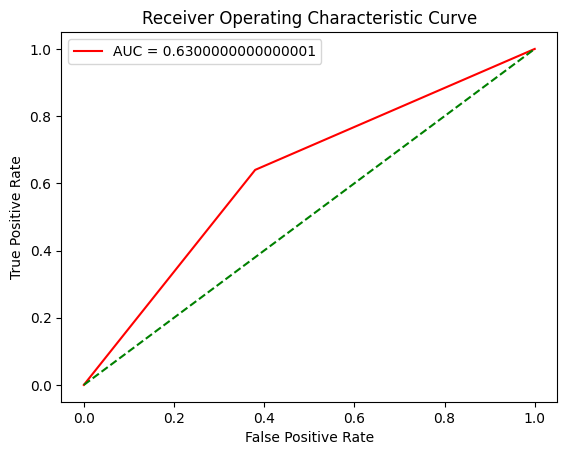

In [ ]:
def plot_roc_curve(fper, tper, AUC):
    plt.plot(fper, tper, color="red", label=f"AUC = {AUC}")
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend()
    plt.show()


fper, tper, thresholds = roc_curve(test_label.to_numpy(), test_pred)
AUC = auc(fper, tper)
plot_roc_curve(fper, tper, AUC)

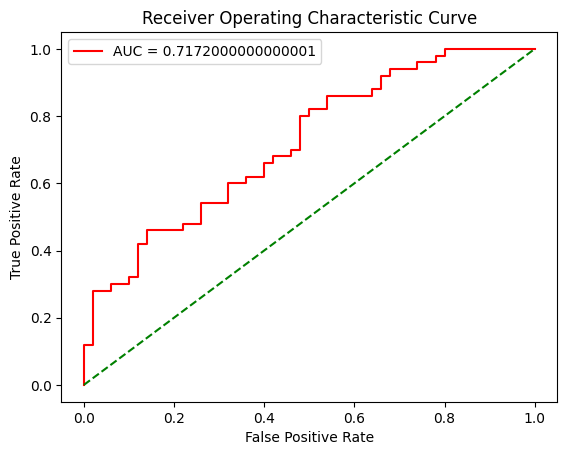

In [ ]:
fper, tper, thresholds = roc_curve(test_label.to_numpy(), probabilities[::,1])
AUC = auc(fper, tper)
plot_roc_curve(fper, tper, AUC)

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

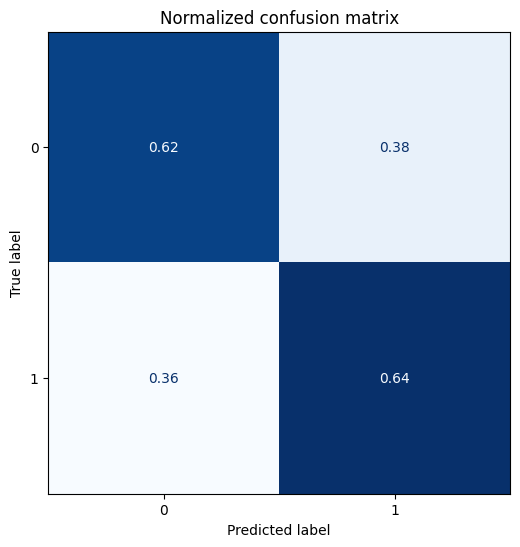

In [ ]:
plot_confusion_matrix(test_pred, test_label.to_numpy())

In [ ]:
print(test_df.columns)

Index(['text', 'pred', 'label'], dtype='object')


In [ ]:
d = {'pred', 'label', 'prob'}
test_df = pd.DataFrame()

test_df['pred'] = test_pred
test_df['label'] = test_label
test_df['prob'] = probabilities[::,1]

test_df

,pred,label,prob
0,1,0,0.546956
1,1,1,0.573684
2,0,0,0.460510
3,1,1,0.663582
4,0,0,0.450339
...,...,...,...
95,1,1,0.844051
96,0,0,0.475277
97,0,0,0.422668
98,0,1,0.488686


In [ ]:
predictions = np.where(test_pred == 1, 1, 0)

output_df = pd.DataFrame({
    'text': test_df['text'],
    'predicted_class': predictions
})

os.makedirs("./BERTs", exist_ok=True)
output_file_path = './BERTs/test_predictions-roBERTa60.csv'
output_df.to_csv(output_file_path, index=False)

print(f'Arquivo de previsões salvo em: {output_file_path}')

Arquivo de previsões salvo em: /content/drive/MyDrive/XAI_E_ML/PIBIC_2024-2025/Comparation-Models/Datas/BERTs/test_predictions-roBERTa60.csv


## **Saving results**

In [ ]:
import shutil

In [ ]:
original_df = pd.read_csv(test_file_path)

original_df['pred'] = test_pred
original_df['prob'] = probabilities[::,1]

os.makedirs("./roBERTa", exist_ok=True)
output_file_path = './roBERTa/test_predictions-roBERTa63.csv'
original_df.to_csv(output_file_path, index=False)

print(f'Arquivo com previsões e probabilidades salvo em: {output_file_path}')

Arquivo com previsões e probabilidades salvo em: /content/drive/MyDrive/XAI_E_ML/PIBIC_2024-2025/Comparation-Models/BERT/roBERTa/test_predictions-roBERTa63.csv


In [ ]:
MODEL_PATH = "/content/roBERTa.bin"
torch.save(model.state_dict(), MODEL_PATH)